Export images to 64 x 64 size

In [1]:
import os
import numpy as np
import glob
import cv2
import pylab as pl
import matplotlib.cm as cm
%matplotlib inline

/home/julien/kaggle/venv/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
DATAPATH = '../data/train'

In [3]:
imgs_fnames = [os.path.basename(fname) for fname in glob.glob(DATAPATH + "/*.tif") if 'mask' not in fname]

In [4]:
len(imgs_fnames)

5635

In [5]:
def load(imgname):
    img_fname = imgname
    mask_fname = os.path.splitext(imgname)[0] + "_mask.tif"
    img = cv2.imread(os.path.join(DATAPATH, img_fname), cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(os.path.join(DATAPATH, mask_fname), cv2.IMREAD_GRAYSCALE)
    
    #newsize = (144, 104)
    # This forces a power-of-two size (which will slightly distort the image)
    newsize = (256, 128)
    img = cv2.resize(img, newsize)
    mask = cv2.resize(mask, newsize)
    return img, mask

(128, 256) (128, 256)


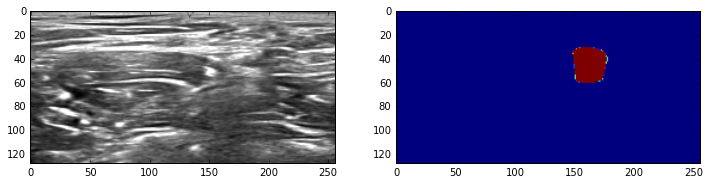

In [6]:
img, mask = load(imgs_fnames[60])
print img.shape, mask.shape
pl.figure(figsize=(12, 4))
pl.subplot(121)
pl.imshow(img, cmap=cm.gray)
pl.subplot(122)
pl.imshow(mask)

In [7]:
# Compute the in-memory size of the whole dataset
size = np.prod(img.shape) * len(imgs_fnames) + np.prod(mask.shape) * len(imgs_fnames)
size_mb = size / (1024.0 * 1024.0 * 1024.0)
print "%f [gb]" % size_mb

0.343933 [gb]


In [8]:
def load_and_preprocess(imgname):
    img_fname = imgname
    # extract patient number so we can do leave-patient-out CV
    pnumber, imnumber = os.path.splitext(imgname)[0].split('_')
    mask_fname = os.path.splitext(imgname)[0] + "_mask.tif"
    img = cv2.imread(os.path.join(DATAPATH, img_fname), cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(os.path.join(DATAPATH, mask_fname), cv2.IMREAD_GRAYSCALE)
    
    #newsize = (img.shape[1] / 4, img.shape[0] / 4)
    newsize = (256, 128)
    img = cv2.resize(img, newsize)
    mask = cv2.resize(mask, newsize)
    mask = (mask > 128).astype(np.float32)
    
    # TODO: Could subtract mean as on fimg above
    img = img.astype(np.float32) / 255.0
    np.ascontiguousarray(img)
    return img, mask, int(pnumber)

# TODO: Note that this load in a different order (but we don't care since it's train) - see test below
imgs, masks, pnumbers = zip(*[load_and_preprocess(fname) for fname in imgs_fnames])

In [9]:
X = np.array(imgs)
print X.shape
print X.nbytes / (1024. * 1024.)

(5635, 128, 256)
704.375


In [10]:
Y = np.array(masks)
print X.shape
print X.nbytes / (1024. * 1024.)

(5635, 128, 256)
704.375


In [11]:
pids = np.array(pnumbers)

In [12]:
np.savez('../data/data_256_128_train.npz', X=X, Y=Y, pids=pids)

In [13]:
del X, Y

In [14]:
TESTPATH = '../data/test'

def load_and_preprocess_test(imgname):
    img = cv2.imread(os.path.join(TESTPATH, imgname), cv2.IMREAD_GRAYSCALE)
    
    #newsize = (img.shape[1] / 4, img.shape[0] / 4)
    newsize = (256, 128)
    img = cv2.resize(img, newsize)
    
    # TODO: Could subtract mean as on fimg above
    img = img.astype(np.float32) / 255.0
    np.ascontiguousarray(img)
    return img

# We want to load in the right order
test_fnames = ['%d.tif' % i for i in range(1,5509)]
test_imgs = [load_and_preprocess_test(fname) for fname in test_fnames]

In [15]:
X = np.array(test_imgs)
print X.shape
print X.nbytes / (1024. * 1024.)

(5508, 128, 256)
688.5


In [16]:
np.savez('../data/data_256_128_test.npz', X=X, test_fnames=test_fnames)